In [33]:
import time
import pandas as pd
import os
import numpy as np
import matplotlib as plt
import tensorflow as tf
from collections import Counter
from sklearn.model_selection import train_test_split

In [34]:
df_volume = pd.read_csv('output.csv') # Path: data\output.csv
df_volume.dtypes


SUBJECT_ID      int64
CHARTTIME      object
VALUE         float64
HAVEAKI         int64
dtype: object

In [35]:
df_volume = df_volume.to_numpy()
#subject_id、尿量、ans
df_volume = np.array([df_volume[:,0], df_volume[:,2], df_volume[:,3]])
# 找出筆數大於等於36的病人
check = []
for key, val in Counter(df_volume[0]).items():
    if val >= 36:
        check.append(key)

# 病人後接上尿量、ans
Dictionary = {}
for i in range(len(df_volume[0])):
    if df_volume[0][i] in check:
        if df_volume[0][i] not in Dictionary:
            Dictionary[df_volume[0][i]] = [[df_volume[1][i], df_volume[2][i]]]
        else:
            Dictionary[df_volume[0][i]].append([df_volume[1][i], df_volume[2][i]])

def Filter1(x):
    li = []
    for i in x:
        li.append(int(i[0]))
    return li

#六小時內會有發生AKI output=1
def Filter2(x):
    li = []
    for i in x:
        li.append(i[1])
    for j in li:
        if j == 1:
            return 1
        else:
            return 0

data = []
ans = []
sequence_length = 36
for key, val in Dictionary.items():
    for index in range(len(val) - sequence_length):
        data.append(Filter1(val[index: index+sequence_length-6])) #1~30
        ans.append(Filter2(val[index+31: index+sequence_length]))


In [36]:
X_train, x_test, Y_train, y_test = train_test_split(data, ans, test_size=0.2)

In [37]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
Y_train = Y_train.reshape((Y_train.shape[0], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1],1))
y_test = y_test.reshape((y_test.shape[0], 1))

In [38]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [39]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers


#model
model = tf.keras.Sequential()
model.add(layers.Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], 1), strides=1, padding='valid', kernel_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(3))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(50,return_sequences=True))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(50))
model.add(layers.Dense(1, activation='sigmoid')) 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


early_stop = EarlyStopping(monitor='val_loss', patience=10)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 24, 32)            256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 32)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 8, 50)             16600     
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 50)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [40]:
from sklearn.utils import class_weight

class_weight_dict = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train.flatten())
class_weight_dict = dict(enumerate(class_weight_dict))

# model dir
model_dir = 'model/'
os.makedirs(model_dir, exist_ok=True)
log_dir = os.path.join(model_dir, 'logs', 'model_CNNLSTM_1')
model_cbk = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = tf.keras.callbacks.ModelCheckpoint(model_dir + 'Best_model_CNNLSTM_1.h5',
                                                monitor='val_accuracy',
                                                save_best_only=True,
                                                mode='max',
                                                early_stop=early_stop)

history = model.fit(X_train, Y_train, epochs=300, batch_size=128, validation_data=(x_test, y_test), callbacks=[model_cbk, model_mckp], class_weight=class_weight_dict)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=[[0]
 [0]
 [1]
 ...
 [0]
 [0]
 [1]] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


TypeError: unhashable type: 'numpy.ndarray'

In [13]:
model.load_weights('model/Best_model_orugin_1.h5')
model.evaluate(x_test, y_test)


438156/438156 [==============================] - 94s 215us/sample - loss: 0.0666 - accuracy: 0.9826


[0.06659152099990824, 0.98255414]

In [ ]:
#draw acc and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

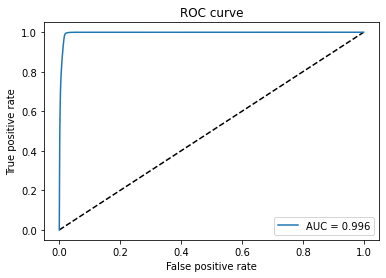

In [15]:
#ROC
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

y_pred = model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()



In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs